<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/88_Ultra_pro_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0_%D0%B8_%D0%B2%D1%8B%D0%B2%D0%BE%D0%B4_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE_%D1%81_%D0%B1%D0%B8%D0%B1%D0%BB%D0%B8%D0%BE%D1%82%D0%B5%D0%BA%D0%BE%D0%B9_gTTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra pro

Макс 10 баллов

В нейронку по созданию чат-бота из занятия «Генерация текста» и добавьте в неё синтез речи, когда бот отвечает на вопрос (чтобы он делал это не текстом, а голосом).

# **Import библиотек**
https://www.youtube.com/watch?v=JSPbJ9CNZ9w&t=10s


In [ ]:
from google.colab import files # модуль для загрузки файлов в colab
import numpy as np # библиотека для работы с массивами данных

from tensorflow.keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adadelta # из кераса загружаем выбранный оптимизатор
from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer # загружаем токенизатор кераса для обработки текста
from tensorflow.keras import utils # загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import plot_model # удобный график для визуализации архитектуры модели

import yaml # импортируем модуль для удобной работы с файлами

In [ ]:
pip install gTTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1


In [ ]:
import gtts
from gtts import gTTS
from io import BytesIO
from IPython.display import Audio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Парсинг данных**
https://www.youtube.com/watch?v=JSPbJ9CNZ9w&t=87s

In [ ]:
######################
# Открываем файл с диалогами
######################
corpus = open('/content/drive/MyDrive/Базы/Диалоги(рассказы)_censored.yml', 'r') # открываем файл с диалогами в режиме чтения
document = yaml.safe_load(corpus) # загружаем файл *глоссарий
conversations = document['разговоры'] # загружаем диалоги из файла и заносим в conversations 
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[123]))
corpus.close()

Количество пар вопрос-ответ : 11893
Пример диалога : ['Перезалил?', 'Да вроде бы нет...']


In [ ]:
######################
# Разбираем вопросы-ответы с проставлением тегов ответам
######################
# Собираем вопросы и ответы в списки
questions = list() # здесь будет список вопросов
answers = list() # здесь будет список ответов

# В каждом диалоге берем фразу и добавляем в лист
# Если в ответе не одна фраза - то сцепляем сколько есть
for con in conversations: # для каждой пары вопрос-ответ
  if len(con) > 2 : # если ответ содержит более двух предложений (кол-во реплик, кол-во вариантов ответа)
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    replies = con[1:] # а ответную составляем из последующих строк
    ans = '' # здесь соберем ответ
    for rep in replies: # каждую реплику в ответной реплике
      ans += ' ' + rep 
    answers.append(ans) #добавим в список ответов
  elif len(con)> 1: # если на 1 вопрос приходится 1 ответ
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    answers.append(con[1]) # а ответную в список ответов

# Очищаем строки с неопределенным типом ответов
answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i]) #если тип - строка, то добавляем в ответы
  else:
    questions.pop(i) # если не строка, то ответ не добавился, и плюс убираем соответствующий вопрос

# Сделаем теги-метки для начала и конца ответов
answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[200]))
print('Ответ : {}'.format(answers[200]))

Вопрос : Около сотни...
Ответ : <START> Точнее! <END>


In [ ]:
######################
# Подключаем керасовский токенизатор и собираем словарь индексов
######################
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
vocabularySize = len(vocabularyItems)+1 # размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('start', 1), ('end', 2), ('что', 3), ('не', 4), ('я', 5), ('а', 6), ('ты', 7), ('это', 8), ('да', 9), ('в', 10), ('нет', 11), ('как', 12), ('и', 13), ('вы', 14), ('ну', 15), ('с', 16), ('на', 17), ('же', 18), ('так', 19), ('он', 20), ('у', 21), ('кто', 22), ('где', 23), ('все', 24), ('мы', 25), ('то', 26), ('мне', 27), ('тебя', 28), ('меня', 29), ('здесь', 30), ('еще', 31), ('почему', 32), ('о', 33), ('тебе', 34), ('там', 35), ('есть', 36), ('его', 37), ('за', 38), ('куда', 39), ('вот', 40), ('ничего', 41), ('вас', 42), ('знаю', 43), ('чем', 44), ('но', 45), ('она', 46), ('они', 47), ('ли', 48), ('чего', 49), ('вам', 50)]
Размер словаря : 15092


# **Подготовка выборки**
https://www.youtube.com/watch?v=JSPbJ9CNZ9w&t=305s

In [ ]:
######################
# Устанавливаем закодированные входные данные(вопросы) https://www.youtube.com/watch?v=JSPbJ9CNZ9w&t=310s
######################
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = paddedQuestions
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 


Пример оригинального вопроса на вход : Какая же мораль?
Пример кодированного вопроса на вход : [ 170   18 5703    0    0    0    0    0    0    0    0]
Размеры закодированного массива вопросов на вход : (11888, 11)
Установленная длина вопросов на вход : 11


In [ ]:
######################
# Устанавливаем раскодированные входные данные(ответы) https://www.youtube.com/watch?v=JSPbJ9CNZ9w&t=375s
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = paddedAnswers # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[100])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[200])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> Никакой. Так просто вспомнилось. <END>
Пример раскодированного ответа на вход : [   1 1743    2    0    0    0    0    0    0    0    0    0    0]
Размеры раскодированного массива ответов на вход : (11888, 13)
Установленная длина ответов на вход : 13


In [ ]:
######################
# Раскодированные выходные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)) : # для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:] # избавляемся от тега <START>
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

In [ ]:
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[100][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [    1   672    19    93 10547     2     0     0     0     0     0     0
     0]
Пример раскодированного ответа на выход : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (11888, 13, 15092)
Установленная длина вопросов на выход : 13


# **Параметры нейросети и модель обучения**
https://www.youtube.com/watch?v=JSPbJ9CNZ9w&t=915s

In [ ]:
######################
# Первый входной слой, кодер, выходной слой https://www.youtube.com/watch?v=JSPbJ9CNZ9w&t=915s
######################
encoderInputs = Input(shape=(None , )) # размеры на входе сетки (здесь будет encoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True) (encoderInputs)
# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
######################
# Второй входной слой, декодер, выходной слой https://www.youtube.com/watch?v=JSPbJ9CNZ9w&t=1048s
######################
decoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет decoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    3018400     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    3018400     ['input_2[0][0]']                
                                                                                              

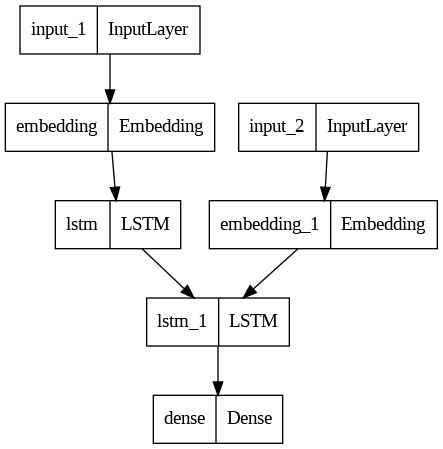

In [ ]:
######################
# Собираем тренировочную модель нейросети https://www.youtube.com/watch?v=JSPbJ9CNZ9w&t=1220s
######################
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary()) # выведем на экран информацию о построенной модели нейросети
plot_model(model, to_file='model.png') # и построим график для визуализации слоев и связей между ними

In [ ]:
# Запустим обучение и сохраним модель https://www.youtube.com/watch?v=JSPbJ9CNZ9w&t=1348s
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=100) 
model.save( '/content/drive/My Drive/Предобученные сети/model_100epochs(rms).h5' )

Epoch 1/100
238/238 [==============================] - 26s 60ms/step - loss: 5.8767
Epoch 2/100
238/238 [==============================] - 7s 30ms/step - loss: 4.9204
Epoch 3/100
238/238 [==============================] - 7s 30ms/step - loss: 4.8438
Epoch 4/100
238/238 [==============================] - 8s 34ms/step - loss: 4.8002
Epoch 5/100
238/238 [==============================] - 7s 29ms/step - loss: 4.7651
Epoch 6/100
238/238 [==============================] - 7s 30ms/step - loss: 4.7304
Epoch 7/100
238/238 [==============================] - 6s 27ms/step - loss: 4.6985
Epoch 8/100
238/238 [==============================] - 7s 29ms/step - loss: 4.6692
Epoch 9/100
238/238 [==============================] - 7s 28ms/step - loss: 4.6471
Epoch 10/100
238/238 [==============================] - 7s 30ms/step - loss: 4.6258
Epoch 11/100
238/238 [==============================] - 7s 28ms/step - loss: 4.6075
Epoch 12/100
238/238 [==============================] - 7s 30ms/step - loss: 4.5905


In [ ]:
# model.compile(optimizer=Adadelta(), loss='categorical_crossentropy')

In [ ]:
# # Запустим обучение и сохраним модель
# model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=2) 
# # model.save( '/content/drive/My Drive/Предобученные сети/model_100epochs(rms) + 50(ada).h5' )

In [ ]:
model.load_weights('/content/drive/MyDrive/Предобученные сети/model_100epochs(rms).h5')

# **Подготовка и запуск рабочей нейросети с генерацией ответов**
https://www.youtube.com/watch?v=JSPbJ9CNZ9w&t=1428s


In [ ]:
######################
# Создаем рабочую модель для вывода ответов на запросы пользователя https://www.youtube.com/watch?v=JSPbJ9CNZ9w&t=1455s
######################
def makeInferenceModels():
  # Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

In [ ]:
######################
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов https://www.youtube.com/watch?v=JSPbJ9CNZ9w&t=1593s
######################
def strToTokens(sentence: str): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list() # здесь будет последовательность токенов/индексов
  for word in words: # для каждого слова в предложении
    tokensList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список

    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем модель https://www.youtube.com/watch?v=JSPbJ9CNZ9w&t=1645s
######################

encModel , decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

# for _ in range(3): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
# Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
# Создаём пустой массив размером (1, 1)
emptyTargetSeq = np.zeros((1, 1))    
emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
decodedTranslation = '' # здесь будет собираться генерируемый ответ
while not stopCondition : # пока не сработало стоп-условие
  # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
  # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
  decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
  
  #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
  sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
  sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
  for word , index in tokenizer.word_index.items():
    if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
      decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
      sampledWord = word # выбранное слово фиксируем в переменную sampledWord
  
  # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
  if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
    stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию


  emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
  statesValues = [h, c] # и состояния, обновленные декодером
  # и продолжаем цикл с обновленными параметрами

print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером
  
text = decodedTranslation[:-3] # сохраняем ответ в переменную text
  
tts_ru = gTTS(str(text), lang='ru')  # переводим ответ в аудио
with open('answer.mp3', 'wb') as f:  # записываем в файл и открываем
  tts_ru.write_to_fp(f)
Audio('answer.mp3', autoplay=True)                  # выводим запись для прослушивания


Задайте вопрос : привет
1/1 [==============================] - 0s 28ms/step
 что вы не знает 


# **Глоссарий**
-  Seq2Seq - sequence-to-sequence модель, состоит из двух рекуррентных нейронных сетей (RNN): 

encoder (кодер), которая обрабатывает входные данные,

decoder (декодер), которая генерирует данные вывода.
- Yaml - удобный текстовый формат, позволяющий хранить структурированные данные в иерархии. https://ru.bmstu.wiki/YAML
yaml.safe_load - безопасный метод загрузки данных из файлов, предотвращающий возможность запуска произвольного кода для файлов из ненадежных источников





